In [1]:
"""
월 차트 조회
"""
import pandas as pd

from repository.maria.conn import maria_home

month_chart = pd.read_sql("""
select month_chart.*, stock.name, stock.exchange
from month_chart
join stock on substring(month_chart.code, -6) = stock.code;
""", maria_home())

month_chart["code"] = month_chart["code"].apply(lambda code: code[-6:])
month_chart

,code,date,open,high,low,close,vol,cap,name,exchange
0,005500,1996-01-31,2366,2650,2193,2555,1904146,129574000000,삼진제약,KOSPI
1,012170,1996-01-31,15102505,16027148,12945004,15256612,108,0,아센디오,KOSPI
2,001880,1996-01-31,11099,11573,9960,10340,103110,37596000000,DL건설,KOSPI
3,005750,1996-01-31,1207,1433,1154,1321,1480732,15104000000,대림B&Co,KOSPI
4,012600,1996-01-31,38136,42304,36990,38969,648262,199988000000,센트럴인사이트,KOSPI
...,...,...,...,...,...,...,...,...,...,...
470824,081580,2022-12-02,2785,2850,2780,2805,207266,43499000000,성우전자,KOSDAQ
470825,122640,2022-12-02,8840,8860,8370,8540,102915,154155000000,예스티,KOSDAQ
470826,215360,2022-12-02,15900,16300,15500,15500,156227,141546000000,우리산업,KOSDAQ
470827,299660,2022-12-02,14400,14750,14100,14150,69551,137693000000,셀리드,KOSDAQ


In [4]:
"""

"""
import repository.deepsearch as ds
from base import Quarter, YearMonth
import sqlite3

con = sqlite3.connect(".cache/cache.db")
try:
    layer1 = pd.read_sql("select * from layer1", con)
except:
    begin = YearMonth(2001, 4)
    end = YearMonth(2022, 11)

    month_chart["년월"] = [YearMonth.of(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    # 그룹핑이 이렇게 되면 안됨.
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.iter(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df1 = df1[df1["vol"] != 0]
        df1 = df1[df1["cap"] != 0]

        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "확정실적": str(Quarter.last_confirmed(ym1.year, ym1.month)),
        })
        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1

        df = df.join(ds.load_and("매출총이익", ym1.year, ym1.month, 4, sum))
        df = df.join(ds.load_and("영업이익", ym1.year, ym1.month, 4, sum))
        df = df.join(ds.load_and("당기순이익", ym1.year, ym1.month, 4, sum))
        df = df.join(ds.load_one("자산", ym1.year, ym1.month))
        df = df.join(ds.load_one("자본", ym1.year, ym1.month))

        layer1 = pd.concat([layer1, df])

layer1

,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,확정실적,매출총이익,영업이익,당기순이익,자산,자본,매도가,매도일,수익률
code,,,,,,,,,,,,,,,,
004830,덕성,KOSPI,2001-04,2001-05,51824000000,2001-04-30,3365,2000-4Q,1.183640e+10,3.411752e+09,3.043678e+09,7.234044e+10,3.869468e+10,3390.0,2001-05-31,0.007429
009320,대우부품,KOSPI,2001-04,2001-05,22438000000,2001-04-30,63564,2000-4Q,3.515454e+10,1.991977e+10,9.855770e+08,3.169646e+11,6.089978e+10,65928.0,2001-05-31,0.037191
033640,네패스,KOSDAQ,2001-04,2001-05,15642000000,2001-04-30,2390,2000-4Q,3.867476e+09,1.313550e+09,3.808550e+08,2.809272e+10,8.006710e+09,2548.0,2001-05-31,0.066109
018290,브이티지엠피,KOSDAQ,2001-04,2001-05,38618000000,2001-04-30,30053,2000-4Q,2.346112e+09,5.217000e+06,4.506810e+08,1.021010e+11,3.223555e+10,30194.0,2001-05-31,0.004692
001540,안국약품,KOSDAQ,2001-04,2001-05,22424000000,2001-04-30,1854,2000-4Q,NaN,NaN,NaN,NaN,NaN,1754.0,2001-05-31,-0.053937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217820,원익피앤이,KOSDAQ,2022-10,2022-11,105919000000,2022-10-31,9200,2022-2Q,4.704265e+09,-2.882083e+09,5.307917e+09,1.131005e+11,5.217515e+10,9060.0,2022-11-30,-0.015217
306040,에스제이그룹,KOSDAQ,2022-10,2022-11,159813000000,2022-10-31,16200,2022-2Q,1.343016e+11,3.738795e+10,2.929271e+10,1.763683e+11,1.196002e+11,16000.0,2022-11-30,-0.012346
016670,디모아,KOSDAQ,2022-10,2022-11,48076000000,2022-10-31,472,2022-2Q,2.146339e+10,3.020122e+09,-1.722091e+10,1.048223e+11,7.006464e+10,634.0,2022-11-30,0.343220


In [4]:
# layer1.to_sql("layer1", sqlite3.connect("../.cache/cache.db"), if_exists="replace")

In [5]:
import numpy as np

result = pd.DataFrame()
for ym in layer1["매수년월"].unique():
    print(f"\r{ym}", end="")
    df = layer1[layer1["매수년월"] == ym]
    factor = pow(sum([df["매출총이익"] / df["자산"], df["영업이익"] / df["자본"]]), 0.4) / df["시가총액"]
    factor[df["매출총이익"] < 0] = np.nan
    factor[df["영업이익"] < 0] = np.nan
    df = df.join(factor.to_frame("factor"))
    df = df.join(df["factor"].rank(ascending=False, method="min").to_frame("rfactor"))
    # fit scale to 1-1000, origin * target-sacle / origin-scale
    result = pd.concat([result, df])

result

2022-10

,index,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,확정실적,매출총이익,영업이익,당기순이익,자산,자본,매도가,매도일,수익률,factor,rfactor
0,0,004830,덕성,KOSPI,2001-04,2001-05,51824000000,2001-04-30,3365,2000-4Q,1.183640e+10,3.411752e+09,3.043678e+09,7.234044e+10,3.869468e+10,3390.0,2001-05-31,0.007429,1.111439e-11,374.0
1,1,009320,대우부품,KOSPI,2001-04,2001-05,22438000000,2001-04-30,63564,2000-4Q,3.515454e+10,1.991977e+10,9.855770e+08,3.169646e+11,6.089978e+10,65928.0,2001-05-31,0.037191,3.203361e-11,160.0
2,2,033640,네패스,KOSDAQ,2001-04,2001-05,15642000000,2001-04-30,2390,2000-4Q,3.867476e+09,1.313550e+09,3.808550e+08,2.809272e+10,8.006710e+09,2548.0,2001-05-31,0.066109,3.958694e-11,112.0
3,3,018290,브이티지엠피,KOSDAQ,2001-04,2001-05,38618000000,2001-04-30,30053,2000-4Q,2.346112e+09,5.217000e+06,4.506810e+08,1.021010e+11,3.223555e+10,30194.0,2001-05-31,0.004692,5.740596e-12,456.0
4,4,001540,안국약품,KOSDAQ,2001-04,2001-05,22424000000,2001-04-30,1854,2000-4Q,NaN,NaN,NaN,NaN,NaN,1754.0,2001-05-31,-0.053937,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418185,418185,217820,원익피앤이,KOSDAQ,2022-10,2022-11,105919000000,2022-10-31,9200,2022-2Q,4.704265e+09,-2.882083e+09,5.307917e+09,1.131005e+11,5.217515e+10,9060.0,2022-11-30,-0.015217,NaN,NaN
418186,418186,306040,에스제이그룹,KOSDAQ,2022-10,2022-11,159813000000,2022-10-31,16200,2022-2Q,1.343016e+11,3.738795e+10,2.929271e+10,1.763683e+11,1.196002e+11,16000.0,2022-11-30,-0.012346,6.438791e-12,455.0
418187,418187,016670,디모아,KOSDAQ,2022-10,2022-11,48076000000,2022-10-31,472,2022-2Q,2.146339e+10,3.020122e+09,-1.722091e+10,1.048223e+11,7.006464e+10,634.0,2022-11-30,0.343220,1.190577e-11,133.0
418188,418188,039290,인포뱅크,KOSDAQ,2022-10,2022-11,105619000000,2022-10-31,12150,2022-2Q,1.773814e+10,3.036469e+09,7.931832e+09,8.867996e+10,6.628003e+10,11700.0,2022-11-30,-0.037037,5.401531e-12,561.0


In [10]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()
strategy = result[result["rfactor"] <= 20].groupby(_key)["수익률"].mean()
result[result["rfactor"] <= 20]

,index,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,확정실적,매출총이익,영업이익,당기순이익,자산,자본,매도가,매도일,수익률,factor,rfactor
35,35,011420,갤럭시아에스엠,KOSPI,2001-04,2001-05,1082000000,2001-04-30,4010,2000-4Q,1.084768e+10,5.240859e+09,8.963800e+08,6.699209e+10,2.251194e+10,4100.0,2001-05-31,0.022444,6.372239e-10,1.0
55,55,003230,삼양식품,KOSPI,2001-04,2001-05,4902000000,2001-04-30,3400,2000-4Q,6.293441e+10,2.228312e+10,-6.191097e+09,3.106237e+11,5.338254e+10,3610.0,2001-05-31,0.061765,1.684968e-10,12.0
111,111,018680,서울제약,KOSDAQ,2001-04,2001-05,8372000000,2001-04-30,1553,2000-4Q,8.491068e+09,3.071029e+09,2.069503e+09,1.645751e+10,1.125521e+10,1634.0,2001-05-31,0.052157,1.086315e-10,20.0
134,134,011150,CJ씨푸드,KOSPI,2001-04,2001-05,2125000000,2001-04-30,2385,2000-4Q,2.776471e+10,1.500921e+09,3.629680e+09,9.128670e+10,-4.569540e+10,2445.0,2001-05-31,0.025157,2.792688e-10,7.0
247,247,002700,신일전자,KOSPI,2001-04,2001-05,1252000000,2001-04-30,1415,2000-4Q,1.237740e+10,4.539775e+09,2.352237e+09,9.067922e+10,1.943000e+10,1434.0,2001-05-31,0.013428,5.367154e-10,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417497,417497,008290,원풍물산,KOSDAQ,2022-10,2022-11,22869000000,2022-10-31,562,2022-2Q,2.026600e+10,6.962400e+07,-7.586255e+09,3.848357e+10,2.131806e+10,608.0,2022-11-30,0.081851,3.391751e-11,2.0
417861,417861,098660,에스티오,KOSDAQ,2022-10,2022-11,45000000000,2022-10-31,3600,2022-2Q,3.868434e+10,1.750995e+09,1.580409e+09,5.872678e+10,2.905260e+10,2770.0,2022-11-30,-0.230556,1.947493e-11,19.0
418055,418055,036000,예림당,KOSDAQ,2022-10,2022-11,37199000000,2022-10-31,1615,2022-2Q,7.015972e+10,8.105463e+10,4.361875e+10,2.164598e+11,1.849066e+11,1855.0,2022-11-30,0.148607,2.411902e-11,10.0
418115,418115,079950,인베니아,KOSDAQ,2022-10,2022-11,35496000000,2022-10-31,1530,2022-2Q,2.713180e+10,1.012522e+10,1.011794e+10,1.319363e+11,5.327108e+10,1590.0,2022-11-30,0.039216,1.944342e-11,20.0


In [6]:
revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})
revisions

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2001-04,2001-05,0.122371,0.115296,-0.01,1.122371,1.115296
2001-05,2001-06,-0.001357,-0.009614,-0.01,1.120848,1.104573
2001-06,2001-07,-0.104704,0.024393,0.13,1.003490,1.131517
2001-07,2001-08,-0.044066,-0.021512,0.02,0.959271,1.107176
2001-08,2001-09,-0.129828,-0.153856,-0.02,0.834730,0.936830
...,...,...,...,...,...,...
2022-06,2022-07,0.062793,0.109127,0.05,28.815353,288126.217348
2022-07,2022-08,0.006397,0.055140,0.05,28.999684,304013.494995
2022-08,2022-09,-0.147563,-0.164790,-0.02,24.720390,253915.242464


<BarContainer object of 259 artists>

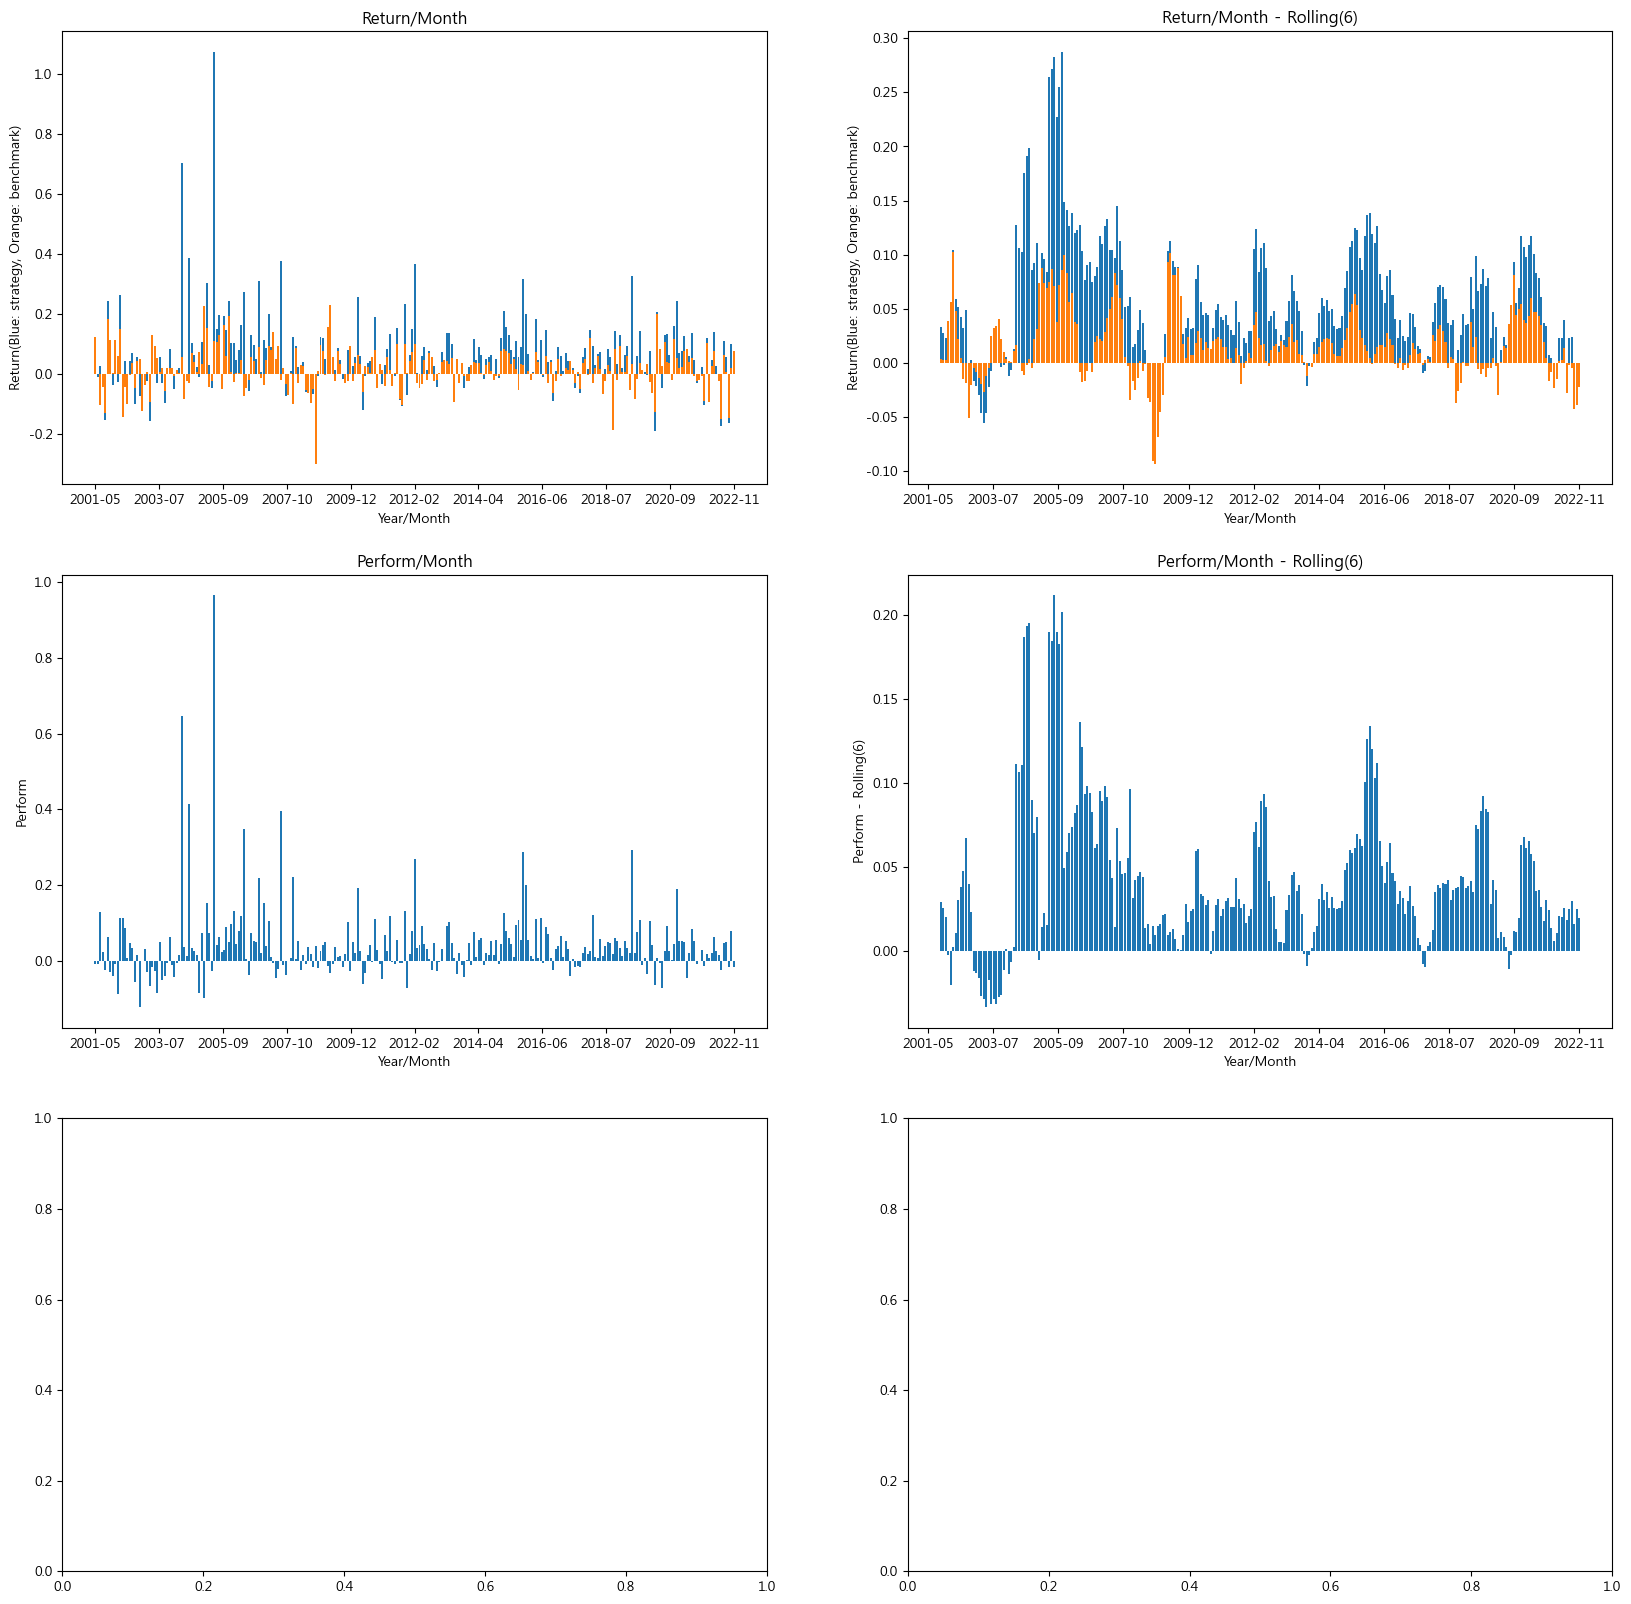

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

x_label = "Year/Month"
y_label = "Return(Blue: strategy, Orange: benchmark)"
ax1.set_title(f"Return/Month")
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))

ax1.bar(x, revisions["전략 수익률"])
ax1.bar(x, revisions["벤치마크 수익률"])

window = 6

ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month"), ax2.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(x, revisions["전략 수익률"].rolling(window).mean())
ax2.bar(x, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title("Perform/Month")
ax3.set_xlabel("Year/Month"), ax3.set_ylabel("Perform")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(x, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax4.set_title("Perform/Month - Rolling(6)")
ax4.set_xlabel("Year/Month"), ax4.set_ylabel("Perform - Rolling(6)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(x, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())


/var/folders/0y/llrn6whd0yv6x4_v5_d124y80000gn/T/ipykernel_88634/609765938.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.update(_df)


          rfactor   revenue
rfactor  1.000000 -0.757005
revenue -0.757005  1.000000
          rfactor   revenue
rfactor  1.000000 -0.666931
revenue -0.666931  1.000000
          rfactor   revenue
rfactor  1.000000 -0.840175
revenue -0.840175  1.000000
전체 수익률 평균 0.013792216095849737


<BarContainer object of 101 artists>

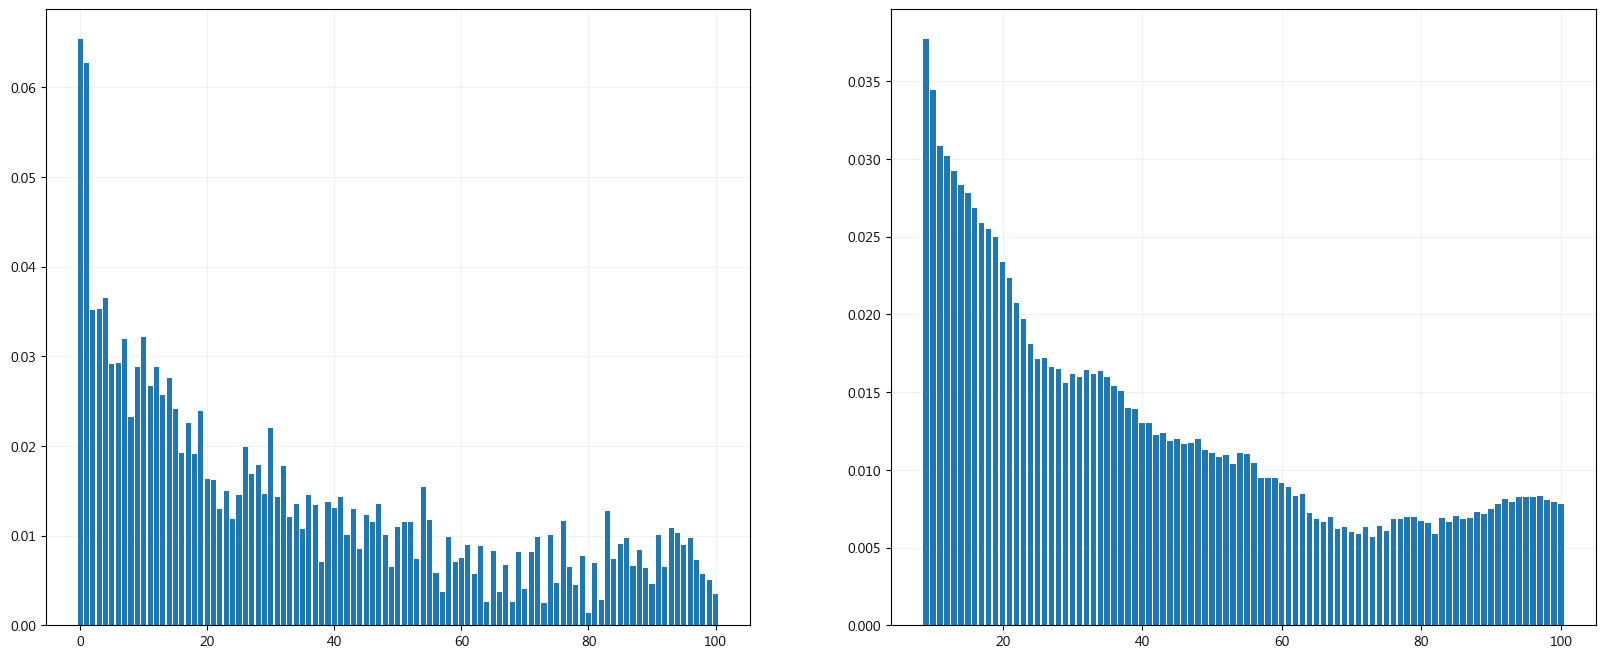

In [8]:
import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

df = result.dropna()

# 팩터 순위 0-100 으로 정규화
for ym in df["매수년월"].unique():
    _df = df[df["매수년월"] == ym]
    _df = round(_df["rfactor"] * 100 / max(_df["rfactor"]))
    df.update(_df)

x = sorted(set(df["rfactor"]))
y = [df[df["rfactor"] == r]["수익률"].mean() for r in x]

return_by_rank = pd.DataFrame({"rfactor": x, "revenue": y})
print(return_by_rank.corr(method="pearson"))
print(return_by_rank.corr(method="kendall"))
print(return_by_rank.corr(method="spearman"))

print("전체 수익률 평균", df["수익률"].mean())

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)

ax1.grid(True)
ax1.bar(x, y, color=["tab:blue" if v > 0 else "tab:red" for v in y])

ax2.grid(True)
y_rolling = pd.Series(y).rolling(10).mean()
ax2.bar(x, y_rolling, color=["tab:blue" if v > 0 else "tab:red" for v in y_rolling])